# <center><span style='background:yellow'> Développez un chatbot pour réserver des vacances</span></center>
# <center><span style='background:yellow'>-----------------</span></center>

## **Sommaire**
1. Chargement de données    
2. Exploration des données
3. Préparation des données
4. Création de l'application LUIS
5. Test de l'application LUIS


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
!pip install azure-cognitiveservices-language-luis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 3.2 MB/s eta 0:00:00


## 1. Chargement de données<a class="anchor" id="1"></a>

### Contenu 
Ce [jeu de données](https://www.microsoft.com/en-us/research/project/frames-dataset/#!download) contient des historiques d’échange entre un chatbot et un utilisateur
Il s'agit des dialogues Frames au format JSON. 
Chaque dialogue a cinq champs principaux :
*   **user_id** 
*   **wizard_id**
*   **id**
*   **userSurveyRating**
*   **Turns**

Ci-dessous les détails des variables

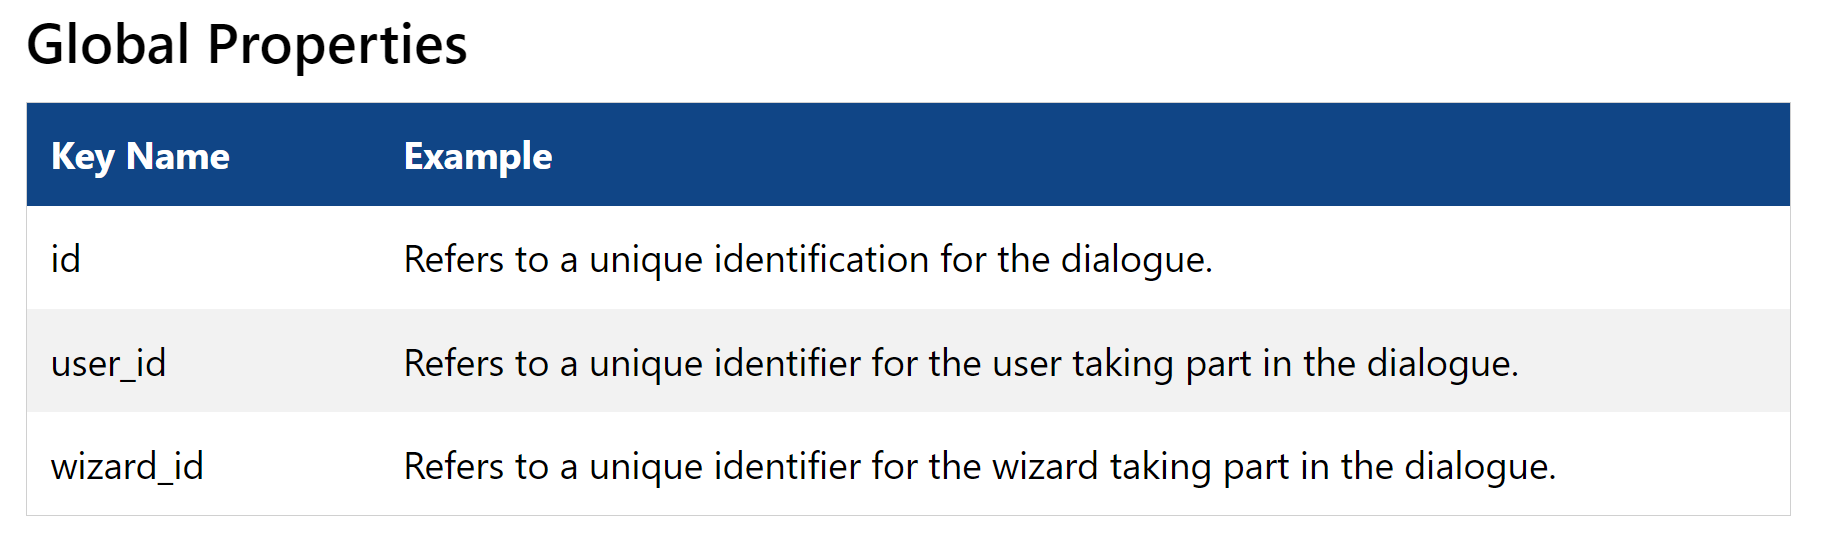

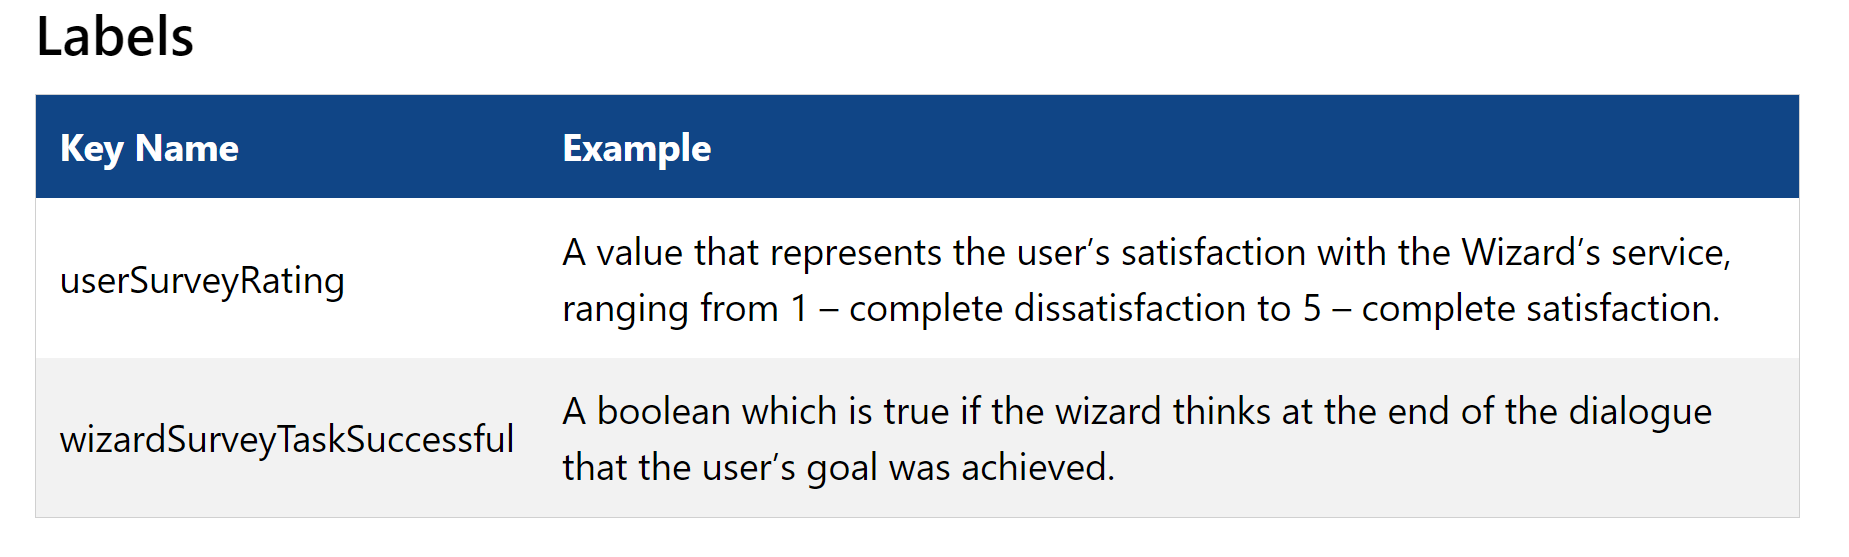

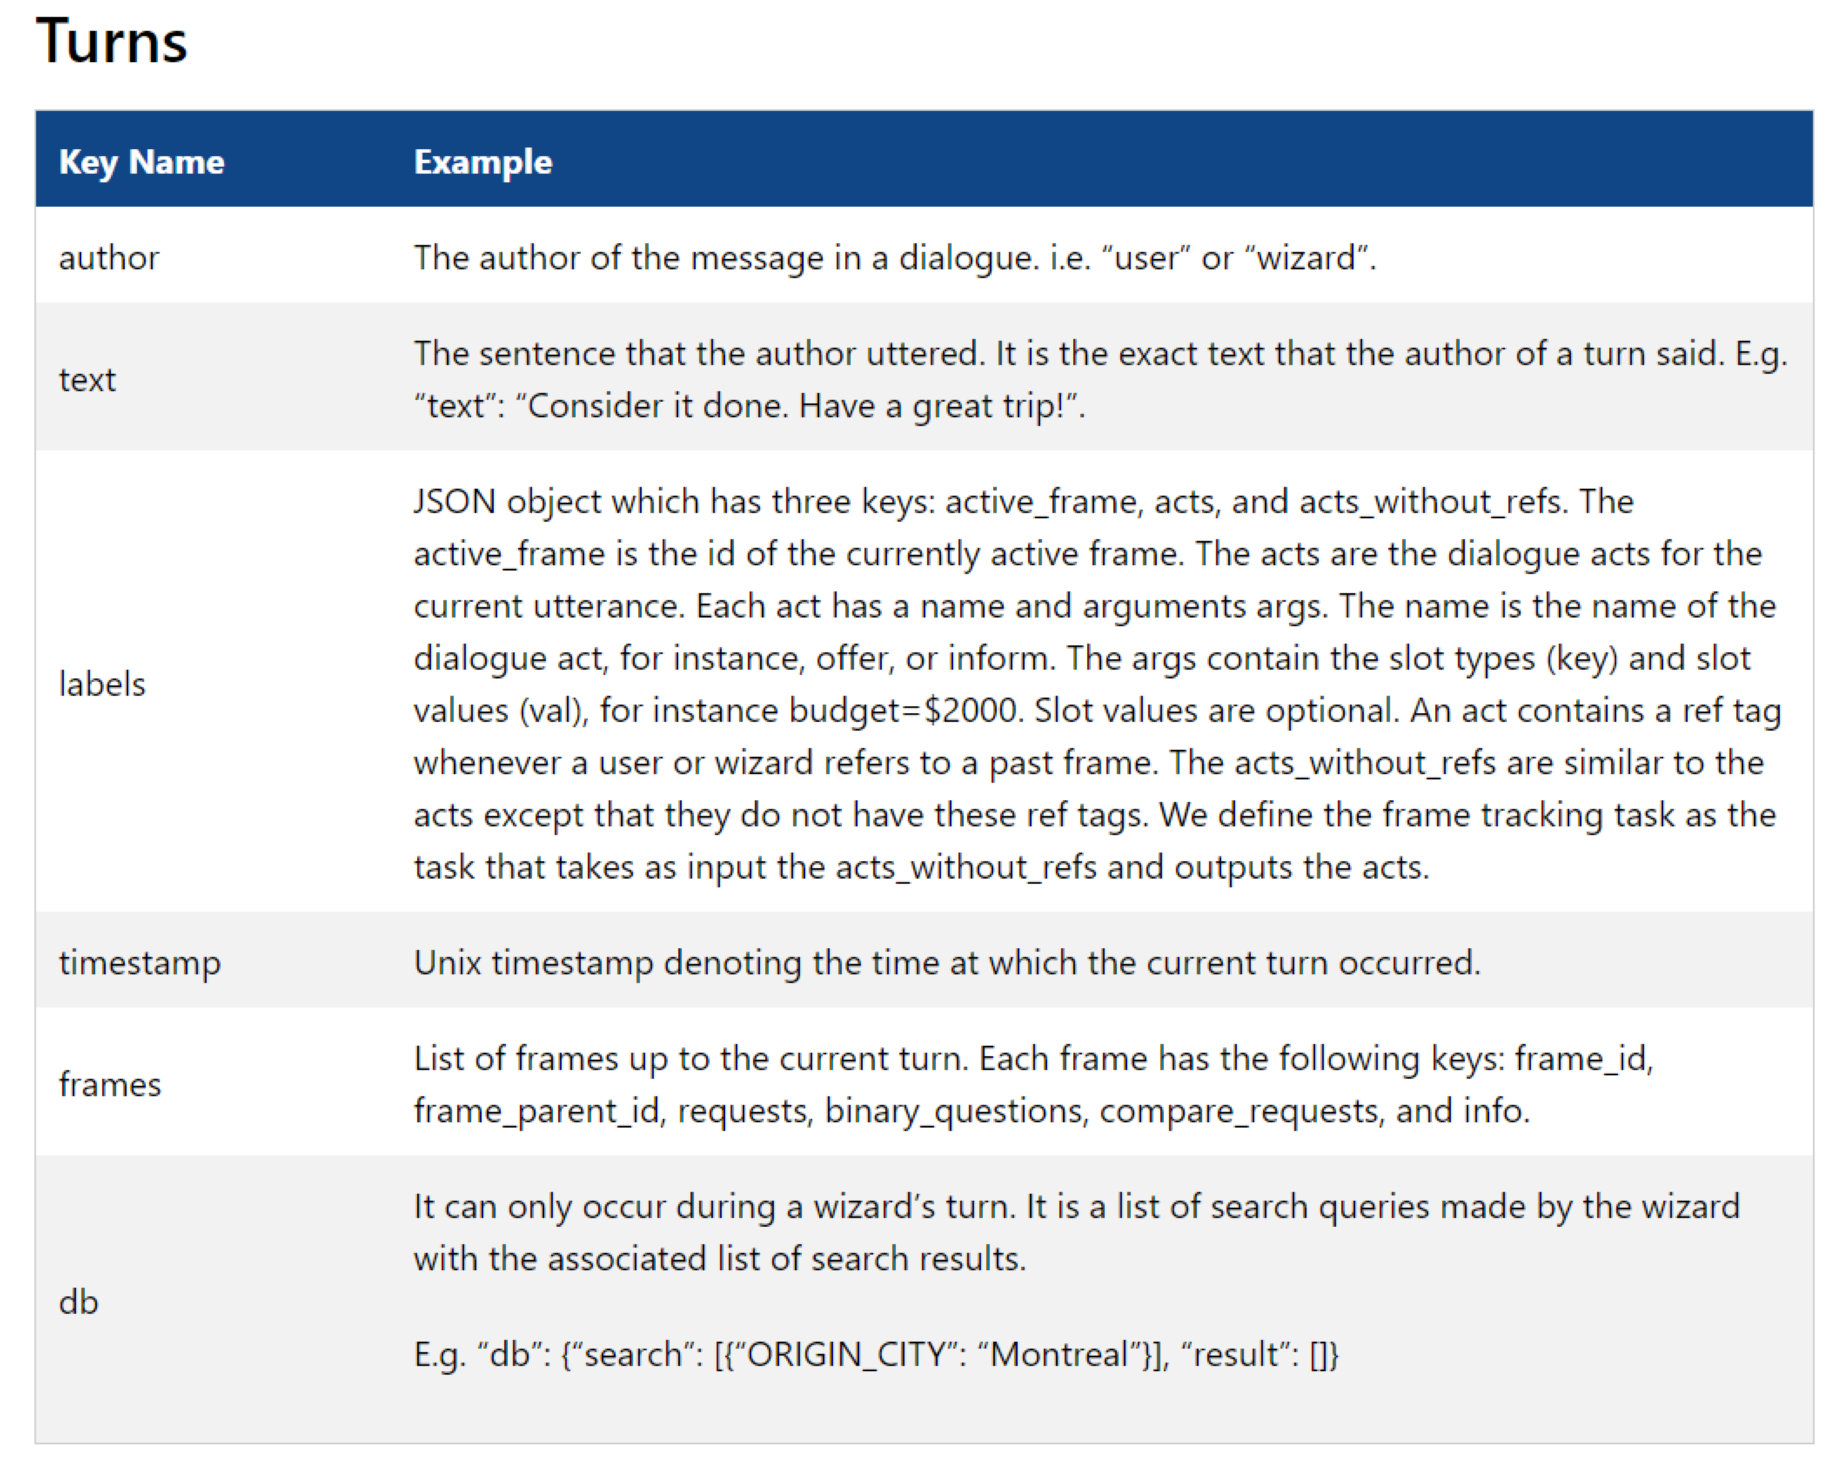

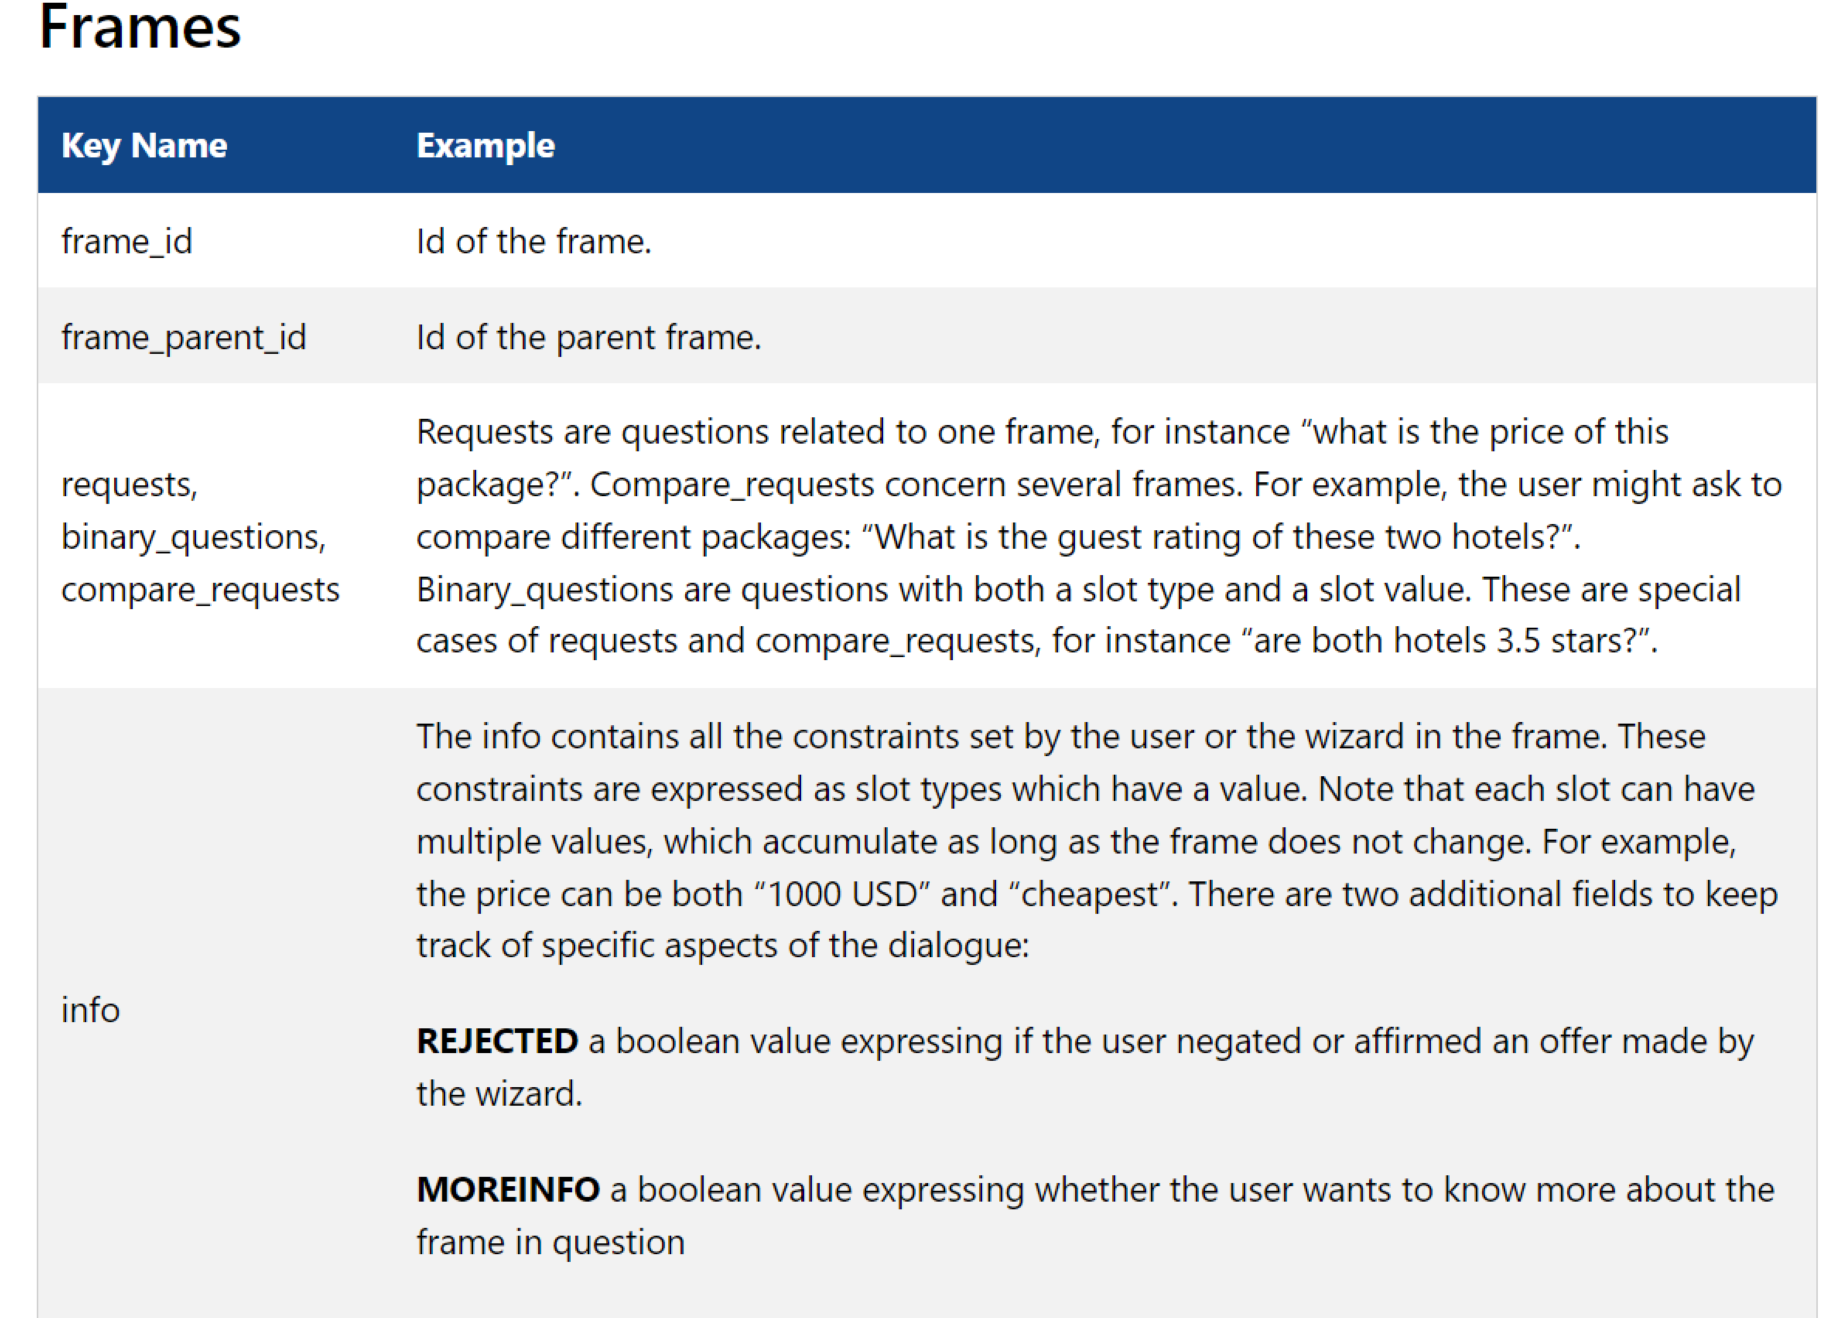

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import json, time, uuid, os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pprint

from azure.cognitiveservices.language.luis.authoring import LUISAuthoringClient
from azure.cognitiveservices.language.luis.authoring.models import ApplicationCreateObject
from azure.cognitiveservices.language.luis.runtime import LUISRuntimeClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.language.luis.authoring.models import ExampleLabelObject
from functools import reduce

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/projet10/"
data_file_path = path + "data/frames/frames.json"

In [ ]:
with open(data_file_path,'r') as f:
  json_data = json.load(f)

In [ ]:
json_data_reduced = json_data[:10]
len(json_data)

1369

In [ ]:
# convetir json en string
json_string = json.dumps(json_data_reduced)

with open('data_reduced.json', 'w') as f:
    # Écrire la chaîne de caractères JSON dans le fichier
    f.write(json_string)

## Exploration des données

In [ ]:
data = pd.read_json(data_file_path)
data.head()

,user_id,turns,wizard_id,id,labels
0,U22HTHYNP,[{'text': 'I'd like to book a trip to Atlantis...,U21DKG18C,e2c0fc6c-2134-4891-8353-ef16d8412c9a,"{'userSurveyRating': 4.0, 'wizardSurveyTaskSuc..."
1,U21E41CQP,"[{'text': 'Hello, I am looking to book a vacat...",U21DMV0KA,4a3bfa39-2c22-42c8-8694-32b4e34415e9,"{'userSurveyRating': 3.0, 'wizardSurveyTaskSuc..."
2,U21RP4FCY,[{'text': 'Hello there i am looking to go on a...,U21E0179B,6e67ed28-e94c-4fab-96b6-68569a92682f,"{'userSurveyRating': 2.0, 'wizardSurveyTaskSuc..."
3,U22HTHYNP,[{'text': 'Hi I'd like to go to Caprica from B...,U21DKG18C,5ae76e50-5b48-4166-9f6d-67aaabd7bcaa,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
4,U21E41CQP,"[{'text': 'Hello, I am looking to book a trip ...",U21DMV0KA,24603086-bb53-431e-a0d8-1dcc63518ba9,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."


In [ ]:
data.shape

(1369, 5)

In [ ]:
data.iloc[0,1][0].keys()

dict_keys(['text', 'labels', 'author', 'timestamp'])

In [ ]:
@interact(indice = widgets.IntSlider(min=0, max=1368, step=1, value=398))
def display_turns(indice=1):
  print('Turns : ')
  pprint.pprint(data.iloc[indice, 1][4])

interactive(children=(IntSlider(value=398, description='indice', max=1368), Output()), _dom_classes=('widget-i…

In [ ]:
a = data.iloc[1, 1][0]['labels']['acts']
a[1].keys()

dict_keys(['args', 'name'])

## Préparation des données

In [ ]:
def get_key_value(arg):
    if "key" in arg and "val" in arg:
        key = arg['key']
        value = arg['val']
        
        return (key, value)
    
    return (None,None)

@interact(indice = widgets.IntSlider(min=0, max=1368, step=1, value=512))
def display(indice):
  print("\n=========================    acts    =========================")

  acts = data.iloc[indice, 1][0]['labels']['acts']
  pprint.pprint(acts)
  print("\n=========================(key, value)=========================")
  for act in acts:
    args = act['args']
    for arg in args:
      print(get_key_value(arg))

interactive(children=(IntSlider(value=512, description='indice', max=1368), Output()), _dom_classes=('widget-i…

In [ ]:
def get_entity_infos(text, key, value):

  text = text.lower()
  value = value.lower()
  start_index = text.find(value)

  if start_index >-1: 
      end_index = start_index + len(value)

      return {
          'entity_name': key,
          'start_char_index': start_index, 
          'end_char_index': end_index}

@interact(indice = widgets.IntSlider(min=0, max=1368, step=1, value=700))
def display(indice=1):
    a = data.iloc[indice, 1][0]['text']
    return get_entity_infos(text=a, key='end_date', value = "september 11")

interactive(children=(IntSlider(value=700, description='indice', max=1368), Output()), _dom_classes=('widget-i…

In [ ]:
intent_name = "FlightBooking"
def get_entity_dict(frame, intent_name=intent_name):

  if frame['author'] == 'user':
      text = frame['text']
      entities_kept = ['or_city','dst_city','str_date','end_date','budget'] 
      acts = frame['labels']['acts']

      entities_label = []

      for act in acts:
          args = act['args']

          for arg in args:
              key, value = get_key_value(arg)

              if key and value and key in entities_kept:
                  entities_label.append(get_entity_infos(text, key, value))         

      dict_output = {
          "text": text,
          "intent_name": intent_name,
          "entity_labels": entities_label
    }
  
  return dict_output

print('\033[1m' + "\n get dictionnary : ") 
@interact(indice = widgets.IntSlider(min=0, max=1368, step=1, value=257))
def display(indice=1):
    a = data.iloc[indice, 1][0]
    # pprint.pprint(a)
    pprint.pprint(get_entity_dict(a)) 


 get dictionnary : 


interactive(children=(IntSlider(value=257, description='indice', max=1368), Output()), _dom_classes=('widget-i…

In [ ]:
# Formatage des données pour appli luis

turns_list = data['turns'].to_list()

utterances = []
for turns in tqdm(turns_list):
  frame = turns[0]
  # pprint.pprint(frame)

  utterances.append(get_entity_dict(frame))

100%|██████████| 1369/1369 [00:00<00:00, 54706.05it/s]


In [ ]:
# Split des données de l'entraînement et données de test

train_utterances, test_utterances = train_test_split(utterances, test_size=0.15, shuffle=True, random_state=0)

## Création de l'application LUIS

In [ ]:
import os 
authoringKey = os.environ.get("AuthoringKey", " ")
authoringEndpoint = os.environ.get("AuthoringEndpoint", " ")
predictionKey = os.environ.get("PredictionKey", "")
predictionEndpoint = os.environ.get("PredictionEndpoint", " ")
client = LUISAuthoringClient(authoringEndpoint, CognitiveServicesCredentials(authoringKey))

In [ ]:
app_version = "0.1"
app_name = "Ticket Booking"

In [ ]:
def creation_luis_app(appName = app_name, versionId = app_version, client = client):

  # We use a UUID to avoid name collisions.
  app_name = appName + str(uuid.uuid4())
  app_version = versionId

  # define app basics
  appDefinition = ApplicationCreateObject(name=app_name, initial_version_id=app_version, culture='en-us')

  # create app
  app_id = client.apps.add(appDefinition)

  # get app id - necessary for all other changes
  print(f"L'application est crée avec succès et son identifiant est {app_id} \n")
  return app_id

def add_settings(intent_name, entities_map, app_id, app_version = "0.1", client = client):
  import numpy as np
  prebuild_entities =  np.unique(list(entities_map.values()))
  entities = list(entities_map.keys())

  # Add intent
  client.model.add_intent(app_id, app_version, name=intent_name)
  print(f"L'intention {intent_name} est ajoutée avec succès et son identifiant est : {app_id} \n")

  # Add prebuild entities
  for prebuild_entity in prebuild_entities:
    prebuilt_entity_id = client.model.add_prebuilt(app_id, app_version, prebuilt_extractor_names = [prebuild_entity])
    # print(f"L'entité {prebuild_entity} est ajoutée avec succès et son identifiant est : {prebuilt_entity_id} \n")

  # Add entities
  for entity in entities:
    entity_id = client.model.add_entity(app_id, app_version, name = entity, feature_relation_create_object={"model_name": entities_map[entity]})
    print(f"L'entité {entity} est ajoutée avec succès et son identifiant est : {entity_id} \n")

In [ ]:
luis_app = creation_luis_app()
entities_map = {'or_city': 'geographyV2', 'dst_city': 'geographyV2', 'str_date': 'datetimeV2', 'end_date': 'datetimeV2', 'budget': 'number'}
add_settings(intent_name="FlightBooking", entities_map = entities_map, app_id = luis_app, app_version = "0.1")

L'application est crée avec succès et son identifiant est 7c5107ea-f684-4128-846c-17bfd959ba2b 

L'intention FlightBooking est ajoutée avec succès et son identifiant est : 7c5107ea-f684-4128-846c-17bfd959ba2b 

L'entité or_city est ajoutée avec succès et son identifiant est : 565310fa-2d4b-4169-9b11-939a51befee6 

L'entité dst_city est ajoutée avec succès et son identifiant est : 7361f5e5-c2cd-4229-8489-91221128c043 

L'entité str_date est ajoutée avec succès et son identifiant est : 858340b1-98a3-45ca-9ae9-9333d3dbd953 

L'entité end_date est ajoutée avec succès et son identifiant est : 6aee816c-9153-4fae-8bd2-893dd4724e70 

L'entité budget est ajoutée avec succès et son identifiant est : 3963b154-1d0c-4507-b133-db800164c050 



In [ ]:
#Add examples
train_len = len(train_utterances)
batch_size = 100
for str_batch in range(0, train_len, batch_size):
    end_batch = str_batch +  batch_size
    
    if end_batch > train_len:
        end_batch = train_len

    client.examples.batch(
                luis_app,
                app_version,
                train_utterances[str_batch:end_batch]
    )



examples = ["When is my flight?", 
            "How are you ?",
            "I need to change my pizza order please", 
            "What is the weather like for today?"]
for example in examples:
  # Créez un objet ExampleLabelObject
  example_label_object = ExampleLabelObject(text=example, entity_labels=[], intent_name="None")

  # Ajouter l'exemple au modèle LUIS
  response = client.examples.add(app_id=luis_app, version_id=app_version, example_label_object=example_label_object)
  print("Labeled Example Utterance:", response)

Labeled Example Utterance: {'additional_properties': {}, 'utterance_text': 'when is my flight?', 'example_id': 17161149585}
Labeled Example Utterance: {'additional_properties': {}, 'utterance_text': 'how are you ?', 'example_id': 17161347145}
Labeled Example Utterance: {'additional_properties': {}, 'utterance_text': 'i need to change my pizza order please', 'example_id': 17161348270}
Labeled Example Utterance: {'additional_properties': {}, 'utterance_text': 'what is the weather like for today?', 'example_id': 17161149587}


In [ ]:
# Train the model
print("Start training the app...")

client.train.train_version(luis_app, app_version)
waiting = True

while waiting:
    info = client.train.get_status(luis_app, app_version)

    # get_status returns a list of training statuses, one for each model. Loop through them and make sure all are done.
    waiting = any(map(lambda x: 'Queued' == x.details.status or 'InProgress' == x.details.status, info))
    if waiting:
        print ("Waiting 10 seconds for training to complete...")
        time.sleep(10)
    else: 
        print("The app is trained !")
        waiting = False
        
# Publish the app
print("Start publishing the app...")

client.apps.update_settings(luis_app, is_public=True)
publish_result = client.apps.publish(luis_app, app_version, is_staging=False)

endpoint = publish_result.endpoint_url + \
            "?subscription-key=" + authoringKey + "&q="

print("The app is published.")

Start training the app...
Waiting 10 seconds for training to complete...
Waiting 10 seconds for training to complete...
The app is trained !
Start publishing the app...
The app is published.


## Test de l'application LUIS

In [ ]:
runtimeCredentials = CognitiveServicesCredentials(predictionKey)
clientRuntime = LUISRuntimeClient(endpoint=predictionEndpoint, credentials=runtimeCredentials)

In [ ]:
def luis_app_prediction(query):

  request = {'query' : query}
  response = clientRuntime.prediction.get_slot_prediction(luis_app, "Production", request)

  return response.prediction

# Test de la fonction
test_len = len(test_utterances)
@interact(indice = widgets.IntSlider(min=0, max=test_len, step=1, value=100))
def display(indice):

  query = test_utterances[indice]['text']

  print("=========================================   Query   =========================================")
  print('Query : \"' + query + '\"')

  print("\n ======================================= Prediction =======================================")
  res_prediction = luis_app_prediction(query)
  print(f"Intent: {res_prediction.top_intent}")
  print("\nPredicted entities : ")
  for key, val in res_prediction.entities.items():
    print(f"- {key} : {val}")

  print("\n ====================================== Real values =======================================")
  entities_name = [entity['entity_name'] for entity in test_utterances[indice]['entity_labels']]
  print("Existed entities")
  for entity_name in entities_name:
    print(f'- {entity_name}')
  

interactive(children=(IntSlider(value=100, description='indice', max=206), Output()), _dom_classes=('widget-in…

In [ ]:
def get_real_entity_values(data):

  text = data['text']
  labels = data['entity_labels']
  dic_entities_values = {}

  if labels != []:

    for entity in labels : 
        if entity : 
          entity_name = entity['entity_name']
          dic_entities_values[entity_name] = text[entity['start_char_index']:entity['end_char_index']]
  
  return dic_entities_values

# Test de la fonction
@interact(indice = widgets.IntSlider(min=0, max=test_len, step=1, value=100))
def display(indice):
  print(get_real_entity_values(test_utterances[indice]))

interactive(children=(IntSlider(value=100, description='indice', max=206), Output()), _dom_classes=('widget-in…

In [ ]:
def get_predicted_entity_values(query):
  
  entities = luis_app_prediction(query).entities
    
  return luis_app_prediction(query).entities

# Test de la fonction
@interact(indice = widgets.IntSlider(min=0, max=test_len, step=1, value=100))
def display(indice):
  text = test_utterances[indice]['text']
  print(get_predicted_entity_values(text))

interactive(children=(IntSlider(value=100, description='indice', max=206), Output()), _dom_classes=('widget-in…

In [ ]:
def luis_app_scores_list(real, pred, entity_name):

  if (len(real) != 0) and (entity_name in real.keys()):

      if entity_name in pred.keys() : 

            if real[entity_name] == pred[entity_name]:
                score = 1
                
            elif real[entity_name] in pred[entity_name]: 
                score = 0.5

            else : 
                score = 0.1
      else : 
            score = 0
  else : 
      score = -1

  return score     

In [ ]:
entities_kept = ['or_city','dst_city','str_date','end_date','budget'] 
evaluate_score = {entity_name : [] for entity_name in entities_kept}

for utterance in tqdm(test_utterances):

    text = utterance['text']
    pred = {key : val[0] for key , val in get_predicted_entity_values(text).items()}
    real = get_real_entity_values(utterance)

    for entity_name in entities_kept : 

        evaluate_score[entity_name].append(luis_app_scores_list(real, pred, entity_name))

100%|██████████| 206/206 [01:40<00:00,  2.06it/s]


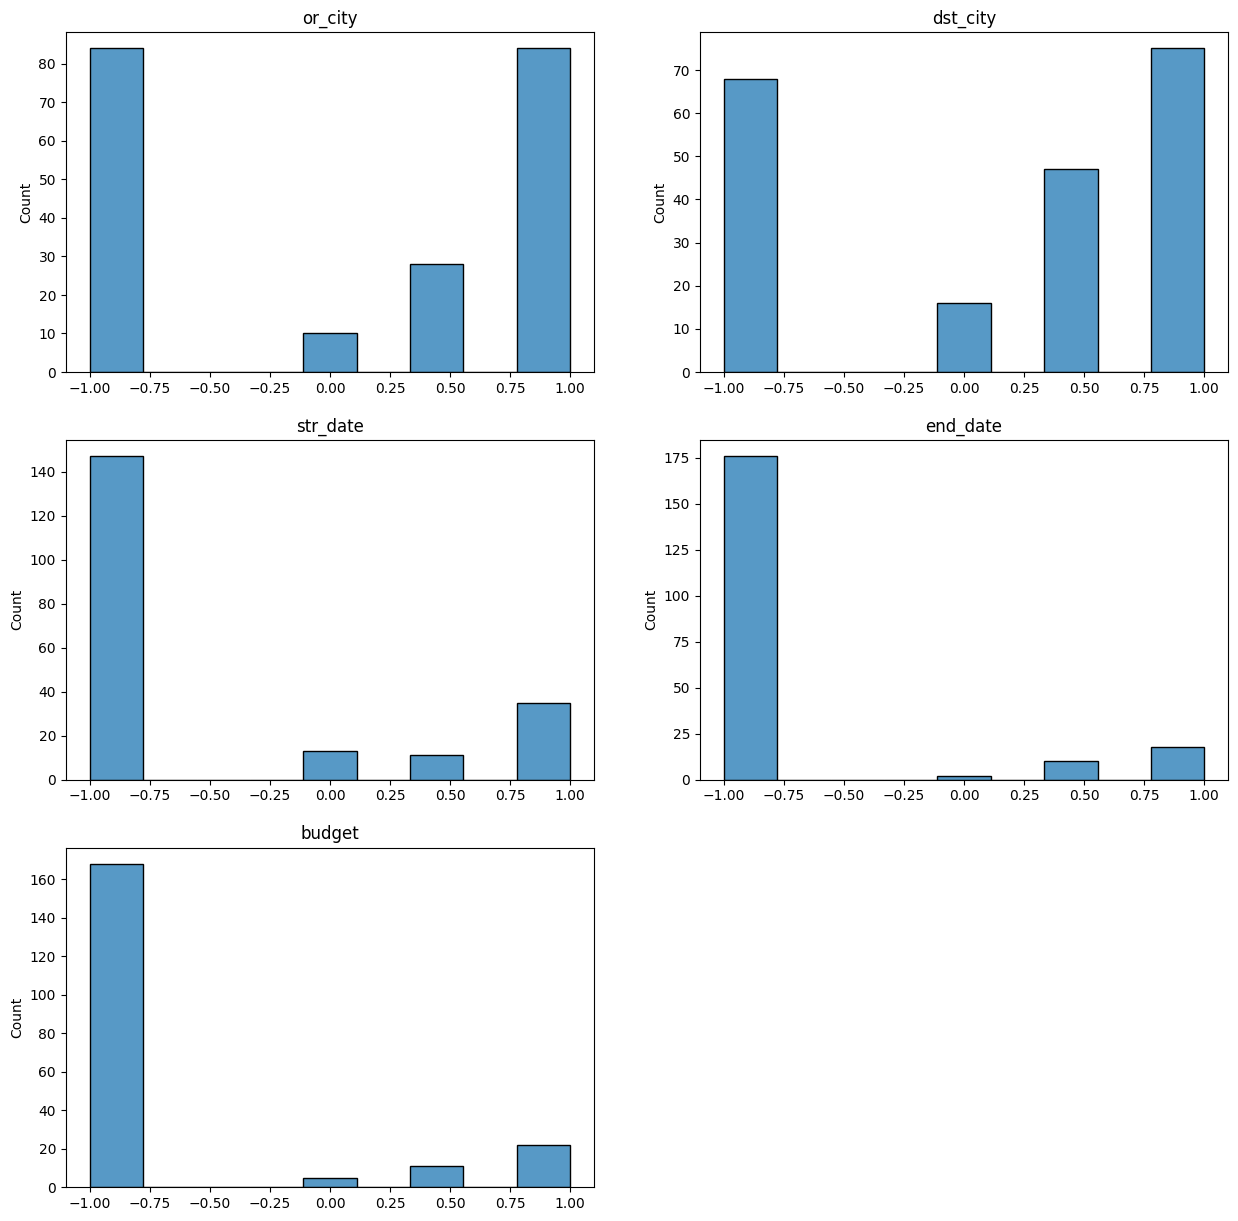

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(15,15))

for i, entity_name in enumerate(entities_kept):

  plt.subplot(3,2,i+1)
  plt.title(f'{entity_name}')
  sns.histplot(evaluate_score[entity_name])

plt.show()

fig.savefig('scores.png')

In [ ]:
def luis_app_entity_accuracy(scores_list):
    acc = np.mean([score for score in scores_list if score != -1])

    return acc

In [ ]:
for entity_name in entities_kept : 

    print(f"L'accuracy pour l'entité {entity_name} : {round(luis_app_entity_accuracy(evaluate_score[entity_name]),3)}")

L'accuracy pour l'entité or_city : 0.807
L'accuracy pour l'entité dst_city : 0.714
L'accuracy pour l'entité str_date : 0.692
L'accuracy pour l'entité end_date : 0.767
L'accuracy pour l'entité budget : 0.726
